# Introduction

This project aims to forecast Google stock price. The data is achieved from Kaggle 
(https://www.kaggle.com/rahulsah06/gooogle-stock-price?select=Google_Stock_Price_Test.csv). The art of forecasting stock prices has been a difficult task for many years. For a good and successful investment, many investors are keen on knowing the future situation of the stock market. Good and effective prediction systems for the stock market help traders, investors, and analyst by providing supportive information like the future direction of the stock market. In this work, we present a recurrent neural network (RNN) and Long Short-Term Memory (LSTM) approach to predict stock market indices.


# Data Understanding and exploration

The data comes with two separate file for train and test data set. So as a first step we read these files and first few rows of these datas are shown.

In [20]:
import pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt

In [203]:
import warnings
warnings.simplefilter(action='ignore')

In [158]:
from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.metrics import mean_squared_error

In [3]:
test = pd.read_csv('Google_Stock_Price_Test.csv.xls')
train = pd.read_csv('Google_Stock_Price_Train.csv.xls')

In [4]:
test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [5]:

train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


Data have total of 6 columns Date,Open,High,Low,Close,Volume. In stock trading, the high and low refer to the maximum and minimum prices in a given time period. Open and close are the prices at which a stock began and ended trading in the same period. Volume is the total amount of trading activity.

Valuable information can be gleaned from understanding the open, high, low, close of a stock, and as well as it’s trading volume. Traders often visualize price actions through bars and bar charts.

<img src="stock.png" width="500" height="500">



In [8]:
print('Shape of the test data is:',test.shape)


Shape of the test data is: (20, 6)


In [9]:
print('Shape of the test data is:',train.shape)

Shape of the test data is: (1258, 6)


The train data have total of 1258 rows and test have 20 rows. So the data is not that of big. Since the data have more than 1000 data we can use deep learning techniques for the forecasting.

In [15]:
print(train.isnull().sum().to_markdown())

|        |   0 |
|:-------|----:|
| Date   |   0 |
| Open   |   0 |
| High   |   0 |
| Low    |   0 |
| Close  |   0 |
| Volume |   0 |


We are interested in attempting to forecast the 'Open' series, which are  prices at which a stock began. Since we don't have any missing values in the data, we do not need to interpolate it.

The distributuion of open values of the stocks is visualized below:



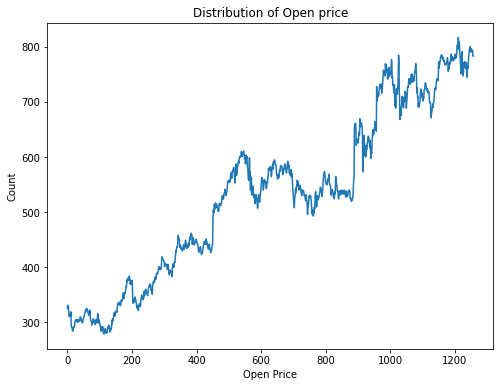

In [25]:
plt.figure(figsize=(8,6))
train['Open'].plot()
plt.xlabel('Open Price')
plt.ylabel('Count')
plt.title('Distribution of Open price');


The distribution of open price shows that, the stocks with high open price are high in number and lower open price stocks are evry low.

Since we are interested in the time series of the data we changed the index of the dataframe to Date column. Now the first few rows of the data is given below:

In [35]:
train.set_index(train.Date,inplace=True)

In [108]:
test.set_index(test.Date,inplace=True)

In [46]:
del train['Date']

In [109]:
del test['Date']

In [47]:
train.head()

,Open,High,Low,Close,Volume
Date,,,,,
1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


The time series changes of the Open price is given below:

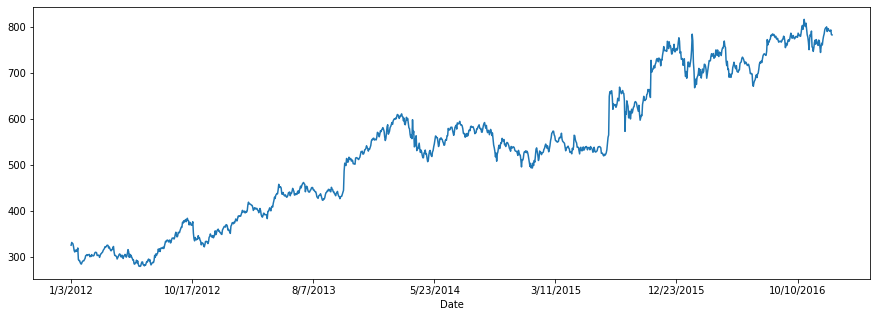

In [49]:
plt.figure(figsize = (15,5))
train['Open'].plot();

So the open price has a trend as time proceeds, The proices tends to increase with short variations.

In [59]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-n_days:] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Open Price Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Time')
    plt.ylabel('Reading')
    plt.xticks(rotation='vertical')
   # plt.set_xticklabels(rotation=45)
    plt.grid(alpha=0.3)

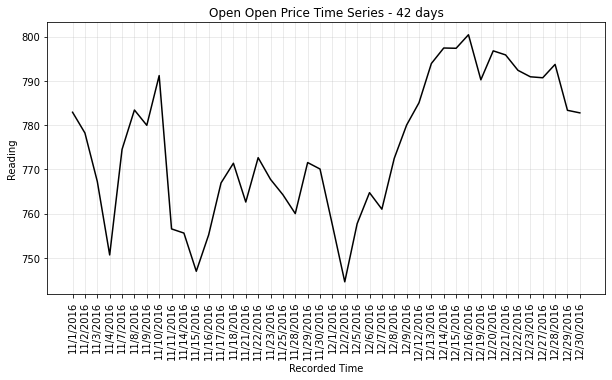

In [62]:
plot_n_last_days(train,'Open', 42)

It is appear to be a periodic component present in the data.


# Preprocessing

The statistical summary of the open price column is given below:


In [64]:
train.Open.describe()

count    1258.000000
mean      533.709833
std       151.904442
min       279.120000
25%       404.115000
50%       537.470000
75%       654.922500
max       816.680000
Name: Open, dtype: float64

We will redefine the train set to include only data and open price, since we need to forecast the opern price only.
We need to scale this column for the ease of deplying deep learning models. Here we will apply the minimax scaling to the column.

In [141]:
train_set = train.iloc[:,0:1].values

In [260]:
#train_set

In [261]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler.fit_transform(train_set)
#train_scaled

Scaled the column to minimum of 0 to maximum of 1 and the distribution after the scaling is,

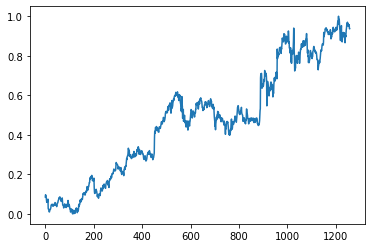

In [86]:
plt.plot(train_scaled)
plt.show()




Before we can train a neural network with keras, we need to process the data into a format that the library accepts. In particular, for keras RNNs and LSTMs, training samples should be stored in a 3D numpy array of shape **(n_samples, time_steps, n_features)**. Since we'll be using only the series' Open Price' to predict its future, we'll only have 1 feature. Also, for the next-step prediction that we'll do in this notebook, target values can be stored in a simple list.

Here we uses all the values in the xtrain for the prediction with 100 timesteps, and defined y as  just the next time step after training sample.




In [94]:
# Creating a data structure with 100 timesteps and 1 output
X_train = []
y_train = []
sample_gap=12
t = 100  # timesteps
l = len(train_scaled)  # l = 1258 in this case
for i in range(t,l):
  X_train.append(train_scaled[i-t:i, 0])
  y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [154]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [144]:
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))


Training input shape: (1158, 100, 1)
Training output shape: (1158,)


Like train set, test set also preprocessed to array of length 20 with 100 timesteps and 1 feauture.

In [153]:
dataset_total = pd.concat((train["Open"], test["Open"]),axis = 0)
inputs = dataset_total[len(train)-len(test)- t:].values.reshape(-1,1)
inputs = scaler.transform(inputs)


In [149]:
X_test = []
y_test = []
for i in range(t, 120):
    X_test.append(inputs[i-t:i, 0])
    y_test.append(inputs[i, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [152]:
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Test input shape: (20, 100, 1)
Test output shape: (20,)



# DataModelling and Forecasting

Now are data is perfect for modelling. First we will start with a simple RNN and evaluate the performance. Then move to more complex model and tune the hyperparameter for better performance. Finally deployes the LSTM model and carries out the performance evaluation.


## RNN 

In [262]:
model = Sequential() 
    
# construct an RNN layer with specified number of hidden units
# per cell and desired sequence input format 
model.add(SimpleRNN(100, input_shape=(X_train.shape[1],1)))
    
    # add an output layer to make final predictions 
model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1);
    

In [241]:
predict_simple_50 = model.predict(X_test)
predict_simple_50 = scaler.inverse_transform(predict_simple_50)

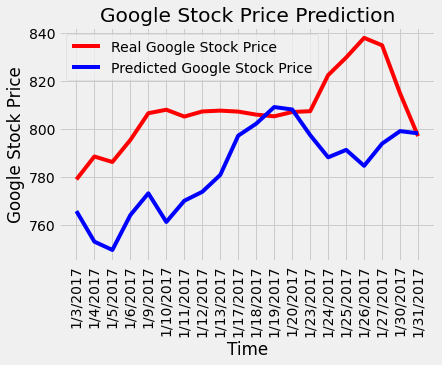

Root mean squared error is 613095.2730573008


In [242]:

plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict_simple_50, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()
MSE_simple = mean_squared_error(y_test,predict_simple)
print('Root mean squared error is',MSE_simple)

In [263]:
model_100 = Sequential() 
    
# construct an RNN layer with specified number of hidden units
# per cell and desired sequence input format 
model_100.add(SimpleRNN(100, input_shape=(X_train.shape[1],1)))
    
    # add an output layer to make final predictions 
model_100.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
model_100.compile(loss='mean_squared_error', optimizer='adam')
model_100.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1);

In [256]:
predict_100 = model_100.predict(X_test)
predict_100 = scaler.inverse_transform(predict_100)

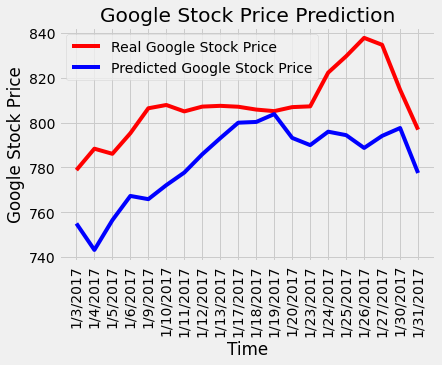

Root mean squared error is 612606.5554208021


In [257]:
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict_100, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()
MSE_simple = mean_squared_error(y_test,predict_100)
print('Root mean squared error is',MSE_simple)

In [167]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [233]:
predict_simple = model.predict(X_test)
predict_simple = scaler.inverse_transform(predict_simple)

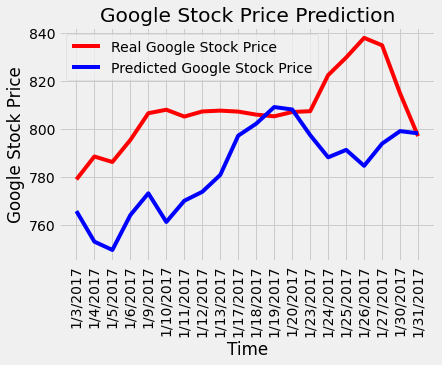

Root mean squared error is 613095.2730573008


In [237]:
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict_simple, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()
MSE_simple = mean_squared_error(y_test,predict_simple)
print('Root mean squared error is',MSE_simple)

The above plot visualize the distribution of Google stock price for both original stock value and the predicted stok value using RNN. The predicted values seems to be not far  away from original values and attained a Mean squared error of '613095.27'. 

Now we will try whether we can improve this forecast prediction further more using more complex RNN, whcih have 3 hidden layers.

In [ ]:






def RNN_model(units,activation,epochs,batch_size):
    Model = Sequential()

# Adding the first RNN layer and some Dropout regularisation
    Model.add(SimpleRNN(units = units,activation=activation, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    Model.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
    Model.add(SimpleRNN(units = units,activation=activation, return_sequences = True))
    Model.add(Dropout(0.2))
 
 #Adding a third RNN layer and some Dropout regularisation. 
    Model.add(SimpleRNN(units = units,activation=activation, return_sequences = True))
    Model.add(Dropout(0.2))
 
 # Adding a fourth RNN layer and some Dropout regularisation.
    Model.add(SimpleRNN(units = units))
    Model.add(Dropout(0.2))


# Adding the output layer
    Model.add(Dense(units = 1))

# Compiling the RNN
    Model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
    Model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    
    return Model

In [ ]:
MSE_model=mean_squared_error(y_test,pred)

In [ ]:
RNN_model_3_layer = RNN_model(50,'tanh',100,32)

In [ ]:
predict_3_layer = RNN_model_3_layer.predict(X_test)
predict_3_layer = scaler.inverse_transform(predict)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()
MSE_3_layer = mean_squared_error(y_test,predict_3_layer)
print('Mean Square value with 3 hidden layer and 50 number of cell is':MSE_3_layer)

So first we deployes a RNN with 50 units, an activation of 50 for an input layer and three hidden layer.

The plot of original and predicted values given below:

In [272]:
Model_1 = Sequential()

# Adding the first RNN layer and some Dropout regularisation
Model_1.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
Model_1.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
Model_1.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
Model_1.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
Model_1.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
Model_1.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
Model_1.add(SimpleRNN(units = 50))
Model_1.add(Dropout(0.2))


# Adding the output layer
Model_1.add(Dense(units = 1))

# Compiling the RNN
Model_1.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
Model_1.fit(X_train, y_train, epochs = 100, batch_size = 32)

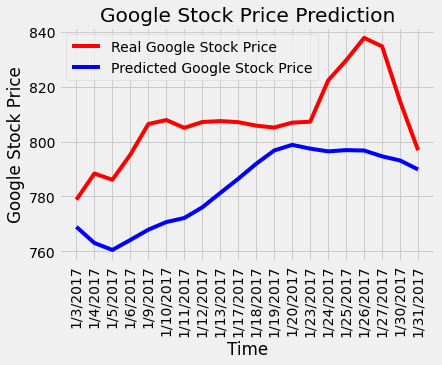

Mean Squared error is 613414.781542415


In [225]:
predict_1 = Model_1.predict(X_test)
predict_1 = scaler.inverse_transform(predict_1)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict_1, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()
MSE = mean_squared_error(y_test,predict_1)
print('Mean Squared error is',MSE)

The above plot shows not much difference from the results of previous model and achieved an MSE of 613414.78.

In [ ]:
RNN_model_3_layer_200 = RNN_model(50,'tanh',200,32)

To inrease the accuracy of prediction, now we will increase the epoch of the above model from 100 to 200 and checks the 

In [ ]:


Model_2 = Sequential()

# Adding the first RNN layer and some Dropout regularisation
Model_2.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
Model_2.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
Model_2.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
Model_2.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
Model_2.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
Model_2.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
Model_2.add(SimpleRNN(units = 50))
Model_2.add(Dropout(0.2))


# Adding the output layer
Model_2.add(Dense(units = 1))

# Compiling the RNN
Model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
Model_2.fit(X_train, y_train, epochs = 200, batch_size = 64)

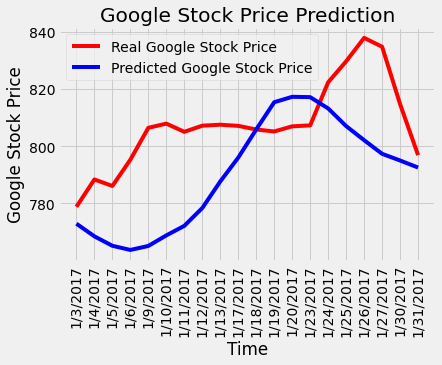

Mean Square value with 3 hidden layer and 50 number of cell is 624400.442683162


In [219]:
predict_model_2= Model_2.predict(X_test)
predict_model_2 = scaler.inverse_transform(predict_model_2)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()
MSE_3_layer_200 = mean_squared_error(y_test,predict_model_2)
print('Mean Square value with 3 hidden layer and 50 number of cell is',MSE_3_layer_200)

When increased the number of epochs , the model seems to have overfitted. The small dips and peaks of the predictions are missing in the new prediction. So it is not a good idea to increase the epoch to 200.

Now we will check changing the activation function to 'relu' would effect the forecasting performance.

In [266]:
Model_3 = Sequential()

# Adding the first RNN layer and some Dropout regularisation
Model_3.add(SimpleRNN(units = 50,activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
Model_3.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
Model_3.add(SimpleRNN(units = 50,activation='relu', return_sequences = True))
Model_3.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
Model_3.add(SimpleRNN(units = 50,activation='relu', return_sequences = True))
Model_3.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
Model_3.add(SimpleRNN(units = 50))
Model_3.add(Dropout(0.2))


# Adding the output layer
Model_3.add(Dense(units = 1))

# Compiling the RNN
Model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
Model_3.fit(X_train, y_train, epochs = 100, batch_size = 64)

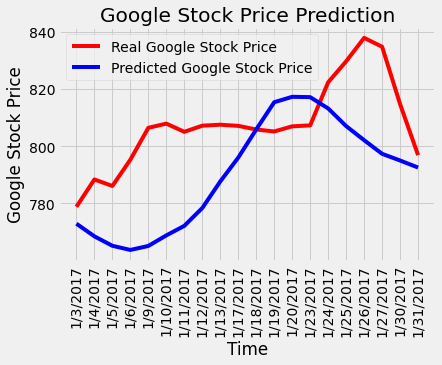

Mean Square value with 3 hidden layer and 50 number of cell is 623029.1496236795


In [220]:
predict_relu = Model_3.predict(X_test)
predict_relu = scaler.inverse_transform(predict_relu)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

MSE_relu = mean_squared_error(y_test,predict_relu)
print('Mean Square value with 3 hidden layer and 50 number of cell is',MSE_relu)


The above figure of the prediciton shows forecasting with 'relu' activation function worsened the prediction. So now we will try the activation function of 'elu'.

In [ ]:
RNN_model_3_layer_elu = RNN_model(50,'elu',100,32)

In [267]:
Model_4 = Sequential()

# Adding the first RNN layer and some Dropout regularisation
Model_4.add(SimpleRNN(units = 50,activation='elu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
Model_4.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
Model_4.add(SimpleRNN(units = 50,activation='elu', return_sequences = True))
Model_4.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
Model_4.add(SimpleRNN(units = 50,activation='elu', return_sequences = True))
Model_4.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
Model_4.add(SimpleRNN(units = 50))
Model_4.add(Dropout(0.2))


# Adding the output layer
Model_4.add(Dense(units = 1))

# Compiling the RNN
Model_4.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
Model_4.fit(X_train, y_train, epochs = 100, batch_size = 64)

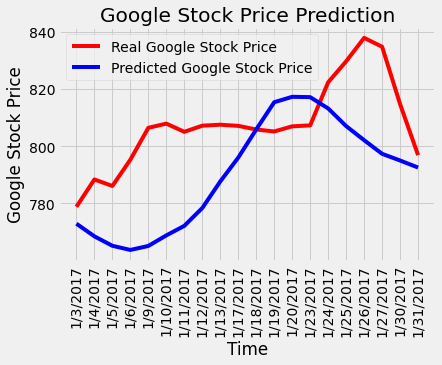

Mean Square value with 3 hidden layer and 50 number of cell is: 617661.3547055001


In [222]:
predict_elu = Model_4.predict(X_test)
predict_elu = scaler.inverse_transform(predict_elu)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

MSE_elu = mean_squared_error(y_test,predict_elu)
print('Mean Square value with 3 hidden layer and 50 number of cell is:',MSE_elu)

The prediciton using 'elu' seems to have done a decent job compared to 'relu'. But the performance is not better from model using 'tanh'.


## LSTM


So far we have tuned hyperparameter of RNN and optimized the forecast prediction based on the Mean square error of the prediciton. Now we will deploy the LSTM model to our data. Since LSTM requires lot of computational power we will limit the tuning to just two steps and analyses the results.

Starts with a simple network without any hidden layers and 10 unit of cells and epoch number of 50 and batch size =1.

In [268]:
model_ls = Sequential()
model_ls.add(LSTM(10, input_shape=(None,1))) # We want to add 10 LSTM block. One layer has 10 LSTM unit (node).
model_ls.add(Dense(1))
model_ls.compile(loss='mean_squared_error', optimizer='adam')
model_ls.fit(X_train, y_train, epochs=50, batch_size=1)

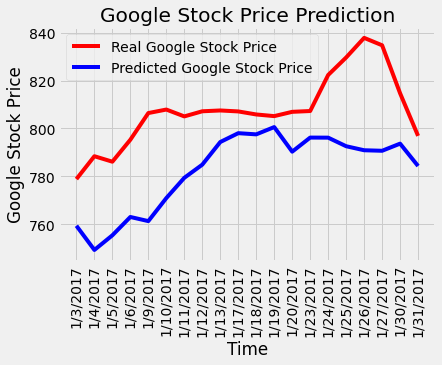

In [207]:
predict = model_ls.predict(X_test)
predict = scaler.inverse_transform(predict)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

In [274]:
#mean_squared_error(y_test,predict)

As expected LSTM gave a better forecasting than the RSTM model. The new MSE is 612266.340 and the plot shows that predicted values are in good resemblence with the original value.

Now we increase the epoch and check whether it increases the precsion of prediction.


In [273]:
model_ls = Sequential()
model_ls.add(LSTM(10, input_shape=(None,1))) # We want to add 10 LSTM block. One layer has 10 LSTM unit (node).
model_ls.add(Dense(1))
model_ls.compile(loss='mean_squared_error', optimizer='adam')
model_ls.fit(X_train, y_train, epochs=100, batch_size=1)

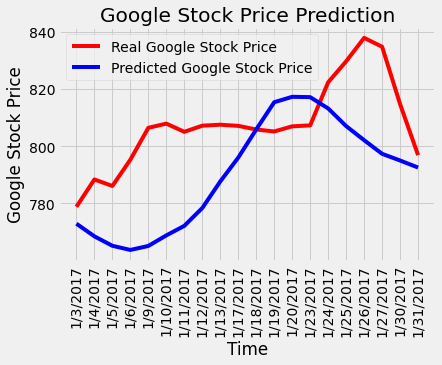

In [248]:
predict_ls_100 = model_ls.predict(X_test)
predict_ls_100 = scaler.inverse_transform(predict_ls_100)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

In [275]:
#mean_squared_error(y_test,predict_ls_100)

The MSE didnt get better compared to the previous model and the model seems to be overfitted from the plot. The MSE is 612825.626.

To increase the prediction better, added three hidden layer to the system

In [269]:
# model_ls_1 = Sequential()

# model_ls_1.add(LSTM(units = 100,return_sequences = True,input_shape = (X_train.shape[1],1)))
# model_ls_1.add(Dropout(0.25))

# model_ls_1.add(LSTM(units = 100,return_sequences = True))
# model_ls_1.add(Dropout(0.25))

# model_ls_1.add(LSTM(units = 100,return_sequences = True))
# model_ls_1.add(Dropout(0.25))

# model_ls_1.add(LSTM(units = 100,return_sequences = True))
# model_ls_1.add(Dropout(0.25))

# model_ls_1.add(LSTM(units = 100))
# model_ls_1.add(Dropout(0.25))


# model_ls_1.add(Dense(1))

# model_ls_1.compile(loss='mean_squared_error', optimizer='adam')
# model_ls_1.fit(X_train, y_train, epochs=50, batch_size=1)

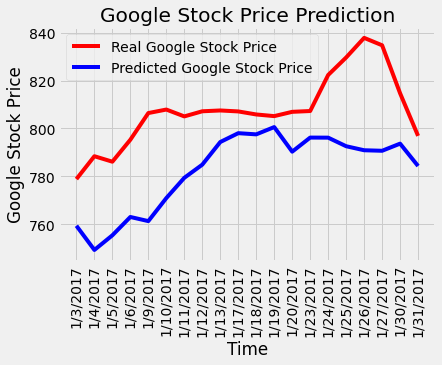

Mean squred error is: 612266.3402352287


In [221]:
predict_ls_1 = model_ls.predict(X_test)
predict_ls_1 = scaler.inverse_transform(predict_ls_1)
plt.plot(test["Open"], color = 'red', label = 'Real Google Stock Price')
plt.plot(predict_ls_1, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()
MSE_ls_1 = mean_squared_error(y_test,predict_ls_1)
print('Mean squred error is:',MSE_ls_1)

Even though we added some more hidden layer to it, the MSE of the prediction didnt improve. It is same as the previous LSTM Model. Also this model needed high computational power.


# Analysis 

The table showing the Meamn squared errror of all the models, we have deployed is given below:

In [258]:
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

MSE = pd.DataFrame({'Model':['Simple_RNN_100_epoch_100cell'
                             ,'Simple_RNN_50_epoch_100cell','RNN_3_layer_100epoch','RNN_3_layer_200epoch','RNN_3_layer_100epoch_relu','RNN_3_layer_100epoch_elu','LSTM 50 epoch',
                            'LSTM 100 epoch','LSTM 3 hidden layer 100 epoch'],
                
                   'MSE' : [612606.55,613095.273,613414.78,624400.4426,623029.1496,617661.354,612266.340,612825.626,612266.340

]})

In [259]:
MSE 

,Model,MSE
0,Simple_RNN_100_epoch_100cell,612606.5500
1,Simple_RNN_50_epoch_100cell,613095.2730
2,RNN_3_layer_100epoch,613414.7800
3,RNN_3_layer_200epoch,624400.4426
4,RNN_3_layer_100epoch_relu,623029.1496
5,RNN_3_layer_100epoch_elu,617661.3540
6,LSTM 50 epoch,612266.3400
7,LSTM 100 epoch,612825.6260
8,LSTM 3 hidden layer 100 epoch,612266.3400


The Mean squared error table above shows the brief information of the performance of the models. Surprisingly the Simple RNN model without any hidden layer has better performance than RNN with 3 hidden layers. The minimum Mean squared error achieved was from the model with 100 cells and 100 epochs.

The LSTM model forecasted the model more precisely compared to RNN, But the computational it need has to taken into account. so the output of these models is not worth its huge computational model. A simple RNN model with minimum computational need provides almost the same prediction result as LSTM.

So considering both the predicting accuracy and Computational need, I would choose a simple RNN model with 100 cell numbers and 100 epochs. Even though this model consumed little computational power, it could provide a result nearly good as LSTM. The huge computational expense of LSTM is a drawback of this model if one doesn't have GPU for the computation. 


# Conclusion and Future Insights

This project aimed to forecast the stock price of Google. For the forecasting, we deployed RNN and LSTM with different hyperparameter tuning. The RNN model with 100 cell numbers and 100 epochs and LSTM model predicted with better accuracy. Since LSTM needs more computational power, a simple RNN is most suitable for future predictions.

We could further tune cell number, epoch, and batch size to check for better performance. Also, we can forecast the close price, low price, and stock price of the stock this way.